# Contextual Bandit Content Personalization
Based on [Contextual Bandit Content Personalization](https://vowpalwabbit.org/docs/vowpal_wabbit/python/latest/tutorials/python_Simulating_a_news_personalization_scenario_using_Contextual_Bandits.html)

In this tutorial we will simulate the scenario of personalizing news content on a site, using CB, to users. The goal is to maximize user engagement quantified by measuring click through rate (CTR).

In a CB setting, a data point has four components,

* Context
* Action
* Probability of choosing action
* Reward/cost for chosen action

In our simulator, we will need to generate a context, get an action/decision for the given context and also simulate generating a reward.

In our simulator, our goal is to maximize reward (click through rate/CTR) or minimize loss (-CTR)

We have two website visitors: ‘Tom’ and ‘Anna’

Each of them may visit the website either in the morning or in the afternoon

The __context__ is therefore `(user, time_of_day)`

We have the option of recommending a variety of articles to Tom and Anna. Therefore, __actions__ are the different choices of articles: “politics”, “sports”, “music”, “food”, “finance”, “health”, “cheese”

The __reward__ is whether they click on the article or not: ‘click’ or ‘no click’

Let’s first start with importing the necessary packages:

In [1]:
import vowpalwabbit
import random
import matplotlib.pyplot as plt
import pandas as pd
import itertools


## Simulate Rewards

In the real world, we will have to learn Tom and Anna’s preferences for articles as we observe their interactions. Since this is a simulation, we will have to define Tom and Anna’s preference profile.

The reward that we provide to the learner will follow this preference profile. Our hope is to see if the learner can take better and better decisions as we see more samples which in turn means we are maximizing the reward.

We will also modify the reward function in a few different ways and see if the CB learner picks up the changes. We will compare the CTR with and without learning.

VW optimizes to minimize __cost which is negative of reward__. Therefore, we will always pass negative of reward as cost to VW.

In [2]:
# VW tries to minimise loss/cost, so pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

The reward function below specifies that Tom likes politics in the morning and music in the afternoon whereas Anna likes sports in the morning and politics in the afternoon.

If the learner recommends an article that aligns with the reward function, we give a positive reward. In our simulated world this is a click.

In [3]:
from content_personalisation import get_cost

## Understand VW format

There are some things we need to do to get our input into a format VW understands. This function handles converting from our context as a dictionary, list of articles and the cost if there is one into the text format VW understands.

In [4]:
from content_personalisation import to_vw_example_format

To understand what’s going on here let’s go through an example. Here, it’s the morning and the user is Tom. There are four possible articles. So in the VW format there is one line that starts with shared, this is the shared context, followed by four lines each corresponding to an article.

In [5]:
context = {
    'user' : 'Tom',
    'time_of_day' : 'morning'
}

actions = ['politics', 'sports', 'music', 'food']

print(to_vw_example_format(context, actions))

shared |User user=Tom time_of_day=morning
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 


## Get a decision
When we call VW we get a pmf, __probability mass function, as the output__. Since we are incorporating exploration into our strategy, VW will give us a list of probabilities over the set of actions. This means that the probability at a given index in the list corresponds to the likelihood of picking that specific action. In order to arrive at a decision/action, we will have to sample from this list.

So, given a list `[0.7, 0.1, 0.1, 0.1]`, we would choose the first item with a 70% chance. `sample_custom_pmf` takes such a list and gives us the index it chose and what the probability of choosing that index was.

In [6]:
from content_personalisation import sample_custom_pmf

We have all of the information we need to choose an action for a specific user and context. To use VW to achieve this, we will do the following:

1. We convert our context and actions into the text format we need
2. We pass this example to vw and get the pmf out
3. Now, we sample this pmf to get what article we will end up showing
4. Finally we return the article chosen, and the probability of choosing it (we are going to need the probability when we learn form this example)

In [7]:
from content_personalisation import get_action

## Simulation Set Up
Now that we have done all of the setup work and know how to interface with VW, let’s simulate the world of Tom and Anna. The scenario is they go to a website and are shown an article. Remember that the reward function allows us to define the worlds reaction to what VW recommends.

We will choose between Tom and Anna uniformly at random and also choose their time of visit uniformly at random. You can think of this as us tossing a coin to choose between Tom and Anna (Anna if heads and Tom if tails) and another coin toss for choosing time of day.

In [8]:
from content_personalisation import choose_user, choose_time_of_day, get_preference_matrix

users = ["Tom", "Anna"]
times_of_day = ["morning", "afternoon"]
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

get_preference_matrix(get_cost, users, times_of_day, actions)

/Users/IFLM/Desktop/vsc/training/contextual_bandit/content_personalisation.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda r: cost_fun({"user": r[0], "time_of_day": r[1]}, r[2]), axis=1


actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0      0.0   0.0     0.0    0.0      -1.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0       0.0    -1.0
Tom   afternoon         0.0      0.0   0.0     0.0   -1.0       0.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0      -1.0     0.0

We will instantiate a CB learner in VW and then simulate Tom and Anna’s website visits `num_iterations` number of times. In each visit, we:

1. Decide between Tom and Anna

2. Decide time of day

3. Pass context i.e. (user, time of day) to learner to get action i.e. article recommendation and probability of choosing action

4. Receive reward i.e. see if user clicked or not. Remember that cost is just negative reward.

5. Format context, action, probability, reward in VW format

6. Learn from the example

VW reduces a CB problem to a cost sensitive multiclass classification problem.

This is the same for every one of our simulations, so we define the process in the `run_simulation` function. The cost function must be supplied as this is essentially us simulating how the world works.

In [9]:
from content_personalisation import run_simulation, plot_ctr

## Scenario 1

We will use the first reward function get_cost and assume that Tom and Anna do not change their preferences over time and see what happens to user engagement as we learn. We will also see what happens when there is no learning. We will use the “no learning” case as our baseline to compare to.

### With Learning

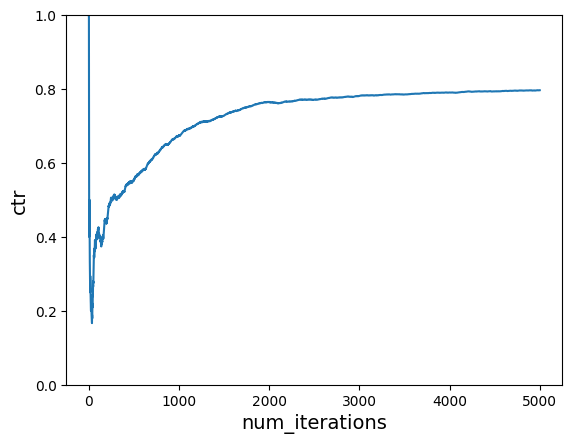

In [10]:
# instantiate learner in VW
vw = vowpalwabbit.Workspace('--cb_explore_adf -q UA --quiet --epsilon 0.2')

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)